# CSII 2024 Exercise 11: Nonlinear Control Part 1
&copy; 2024 ETH Zurich, Felix Schnitzler, Jungcheng Fu, Dejan Milojevic, Paolo Petri, Joël Gmür; Institute for Dynamic Systems and Control; Prof. Emilio Frazzoli

## Description
This week's Jupyter notebook will cover feedback linearization and differential flatness.


As usual, we start by installing the `control` module and import the required libraries.

In [2]:
# Install the required python library with pip 
%pip install control

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: C:\Users\elias\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import control as ct
import control.flatsys as fs
import matplotlib.pyplot as plt

## Problem 1
You are an engineer on a racing team for Formula 1 and you are currently working on optimizing the drag force on your teams racecar. To model the vehicles behaviour you need to recall the equation for Drag force that you first learned about at ETH.
$$ F_{d} = \frac{1}{2}\rho c_d A\dot{x}(t)^2 , $$ 
where $\rho$ is the density of air, $c_d$ is the drag coefficient and $A$ is the affected reference area.
We model the total force $F_{tot}$ on the vehicle as the combination of the input acceleration $u(t)$ and the drag force $F_d$:
$$ F_{tot} = m u(t) - F_d$$
Writing this in familiar notation we get:
$$ m\ddot{x}(t) = -\frac{1}{2}\rho c_d A\dot{x}(t)^2 + mu(t)$$
Since we are interested in the velocity of the system, we can transform this into a first order differential equation by setting $v(t) = \dot{x}(t)$. The total system now reads:
\begin{align*}
\dot{v}(t) &= -\gamma v(t)^2 + u(t)\\
y(t) &= v(t)
\end{align*}
where $\gamma = \frac{1}{2m}\rho c_d A$ and $y(t)$ is the output of the system.

For better understanding, we can think $u(t)$ as the "Gas Pedal Position".


### Exercise 1.1

Define the nonlinear system in the function 'nonlinear_system' below. The function should take the state $x$, the input $u$ and the parameters $\gamma$ as arguments and return the derivative of the state $vdot$ as well as the output $y$.

You can use the following information to evaluate $\gamma$:

$m = 800kg$, $\rho = 1.293 \frac{kg}{m^3}$, $c_d = 1.1$, $A = 1.38$

In [4]:
gamma = 1.293 * 1.1 * 1.38 * 1 / (2 * 800)

def nonlinear_sys(t, v, u, params=(gamma)):
  vdot = -gamma*v**2 + u
  return vdot

def nonlinear_sys_out(t, v, u, params=(None)):
  y = v
  return y

### Exercise 1.2

Using the control library, define the input-output system `sys` and simulate the response of the system.
Hint: You can use the function `ct.NonlinearIOSystem()` to define `sys`.

In [5]:
# TODO: create a system object in Python
# sys = 

Solution:

In [76]:
# Solution
sys = ct.NonlinearIOSystem(nonlinear_sys, nonlinear_sys_out)

We will analyse the cars behaviour in response to an input acceleration of $20 \frac{m}{s^2}$ or approximately 2G's, using the function `ct.input_output_response()`.

In [77]:
t = np.linspace(0, 30, 1000)
u = 20

t_out_1, y_out_1 = ct.input_output_response(sys, T=t, U=u, X0=[0])

The next block plots the reaction of the car due to the acceleration input $u$. Note that there seems to be a point where the car does not accelerate anymore. This is the speed where the drag force becomes so strong that the car remains at a equilibrium velocity. This operation point is called stagnation speed.

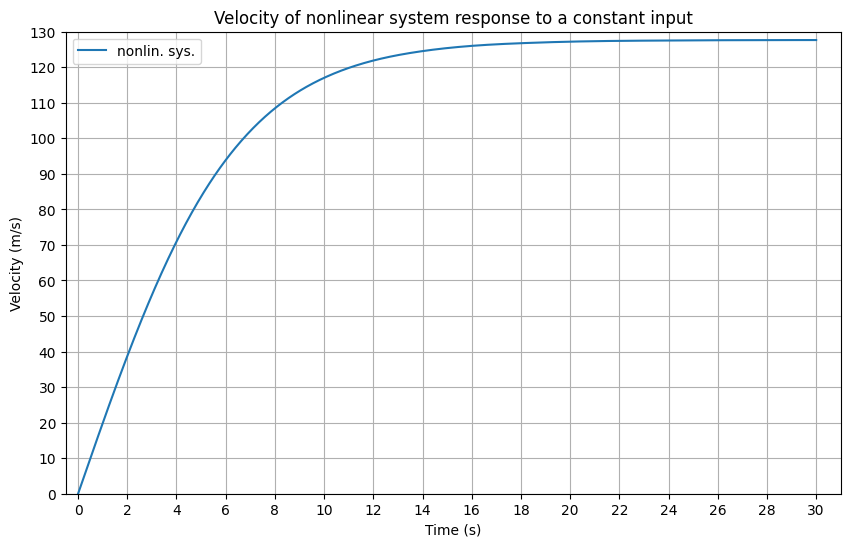

In [78]:
# Plot the response
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.title('Velocity of nonlinear system response to a constant input')
plt.plot(t_out_1, y_out_1[0], label='nonlin. sys.')
plt.xticks(np.linspace(0, 30, 16))
plt.yticks(np.linspace(0,130,14))
plt.ylim(0,130)
plt.xlim(-0.5,31)
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.show()

### Exercise 1.3

We know that the drag force is quadratic to relative airspeed. So, at high airspeed, a small gust of wind can create a huge change in drag force. Noticed that wind gust speed relative to ground maybe for example $\pm 5\frac{m}{s}$. But the car already has a speed of $127\frac{m}{s}$ relative to the ground, and thus already has an airspeed of $127\frac{m}{s}$. This wind gust add or minus another $5\frac{m}{s}$ on top of the $127\frac{m}{s}$ makes it $132\frac{m}{s}$ or $122\frac{m}{s}$. This added disturbance will have a huge acceleration impact on the car itself since the drag force is quadratic to relative airspeed.

To be able to control the car under this turbulence more efficiently, we linearize the system around a certain state. We have multiple approaches to find a state that we want to do the linearization. Here we introduce a function `ct.ct.find_eqpt()` to find the equilibrium point, here is the stagnation speed. Assume that we still have the same input acceleration of $u = 20\frac{m}{s^2}$ with ground wind speed $0\frac{m}{s}$. What is the stagnation relative airspeed and ground speed of the car?


_Hint: The system function is symmetrical, thus, when the initial state $x_0 = 0$, it may take the negative solution. Set a slight positive number to get a positive solution_.


In [79]:
# TODO:
# v_eq,u_eq,y_eq = 

# print("Input acceleration u_eq =", u_eq[0], "m/s^2")
# print("Stagnation speed y_eq =", y_eq[0],"m/s")

Solution:

In [80]:
# Solution
v_eq,u_eq,y_eq = ct.find_eqpt(sys, [0.01], [20], return_y=True)

print("Input acceleration u_eq =", u_eq[0], "m/s^2")
print("Stagnation airspeed v_eq =", v_eq[0],"m/s")
print("Stagnation ground speed = v_eq =", y_eq[0],"m/s")

Input acceleration u_eq = 20 m/s^2
Stagnation airspeed v_eq = 127.68498827514793 m/s
Stagnation ground speed = v_eq = 127.68498827514793 m/s


### Exercise 1.4

Linearize the system around the equilibrium point we found from the previous exercise $(v_{eq}, u_{eq})$ using `ct.linearize()`. The system can now be written as a state-space model:

\begin{align*}
\Delta \dot{v}(t) &= A \cdot \Delta v(t) + B \cdot \Delta u(t)\\
\Delta y(t) &= D \cdot \Delta v(t) 
\end{align*}

Additionally, print the system's A matrix. 

Is this system stable?


In [81]:
# TODO:
# linearized_sys =

# A_matrix =
# print(A_matrix)

Solution:

In [82]:
# Solution

linearized_sys = ct.linearize(sys,[v_eq],[u_eq])

A_matrix = linearized_sys.A

print(A_matrix)

[[-0.31327097]]


### Exercise 1.5

Now we have our linearized system, we want to use this system model to predict the behavior of our real nonlinear system in response to the disturbance of the wind. 

The linearized system simply takes the slope of the nonlinear function at that given state point $(v_{eq}, u_{eq})$ and doesn't have an offset. So the calculation with the linearized system will be only using the change of airspeed $\Delta v(t)$ and input $\Delta u(t)$.

Assume the car is already at the stagnation speed, at $t=0s$, we have a gust of wind of $1\frac{m}{s}$ as a unit step disturbance, against the car's travel direction. 

Now the car experiences a change of airspeed $\Delta v(t)=1\frac{m}{s}$. Plot the linearized system response.

In [83]:
# TODO:

# t_1 = np.linspace(0, 30, 3000)
# delta_v = 1
# delta_u = 

# t_out, delta_y_out = ct.input_output_response(linearized_sys, T=t_1, U=delta_u, X0=delta_v)

# Plot the response
# plt.figure(figsize=(10, 6))
# plt.title('Velocity of linear system response to a disturbance')
# plt.plot(t_out, delta_y_out)
# plt.xlabel('Time (s)')
# plt.ylabel('Velocity (m/s)')
# plt.grid(True)
# plt.show()

Solution:

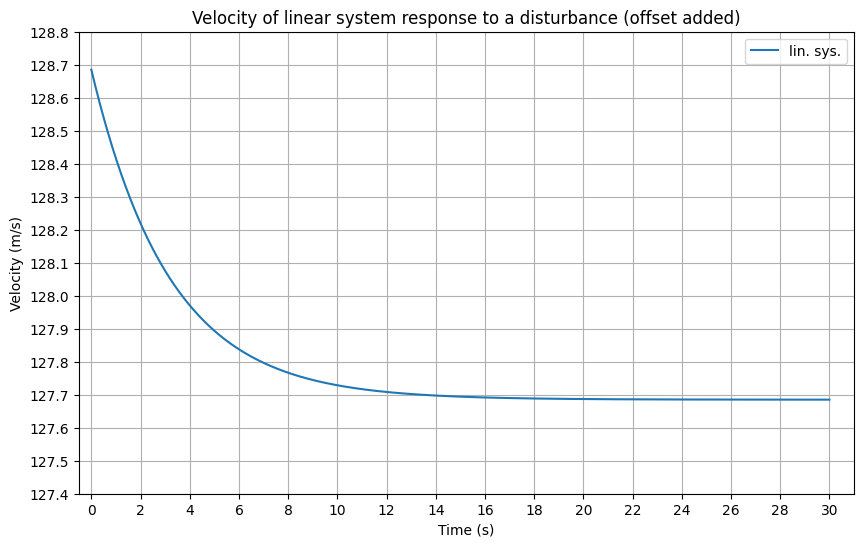

In [85]:
# Solution
t_1 = np.linspace(0, 30, 3000)
delta_v = 1
delta_u = 0

t_out, delta_y_out = ct.input_output_response(linearized_sys, T=t_1, U=delta_u, X0=delta_v)

# This adds the offset to the linearized system
v = delta_y_out + v_eq

# Plot the response
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.title('Velocity of linear system response to a disturbance (offset added)')
#plt.plot(t_out[100:], y_out[0][100:], label='y=v')
plt.plot(t_out, v, label='lin. sys.')
plt.xticks(np.linspace(0, 30, 16))
plt.yticks(np.linspace(127,129,21))
plt.ylim(127.4,128.8)
plt.xlim(-0.5,31)
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.show()

Here we compare the nonlinear system response side by side with the linearized (offset added) system model. Does our linearized system predict the behavior of the nonlinear system at around the linearized point?

Now try some different values in $\Delta v(t)$ and input $\Delta u(t)$ (some values which are far from the linearized point).

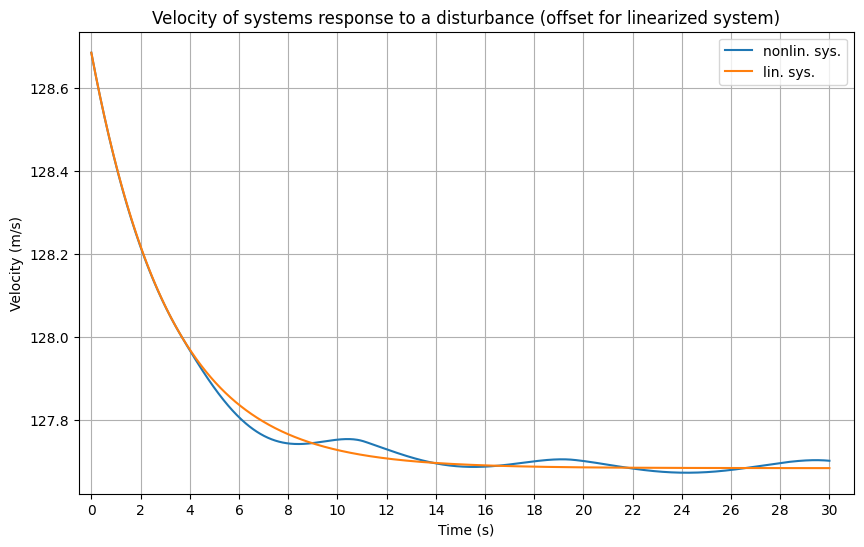

In [102]:
# Simulate the linearized system response
t_1 = np.linspace(0, 30, 3000)
delta_v = 1
delta_u = 0
t_lin, delta_y_out = ct.input_output_response(linearized_sys, T=t_1, U=delta_u, X0=delta_v)

# This adds the offset to the linearized system
v = delta_y_out + v_eq


# Simulate the nonliner system response
t = np.linspace(0, 30, 1000)
u = 20 + delta_u
t_NL, y_out = ct.input_output_response(sys, T=t, U=u, X0=v_eq+delta_v)


# Plot the response
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.title('Velocity of systems response to a disturbance (offset for linearized system)')
plt.plot(t_NL, y_out[0], label='nonlin. sys.')
plt.plot(t_lin, v, label='lin. sys.')
plt.xticks(np.linspace(0, 30, 16))
plt.xlim(-0.5,31)
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.legend()
plt.show()

we noticed that the linearized system gives a very similar response compared with the nonlinear one.

Conclusion:
Using this, we can linearize a nonlinear function around any point and make a LTI system with matrixes A,B,C,D to apply our familiar control theories.